In [7]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [8]:
# 데이터 경로
data_dir = "data"
valid_size = 0.2 # 20%를 테스트 데이터로 사용

In [23]:
# 이미지 변환 설정 (ResNet50에 맞춤)
transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # 224x224로 변환
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5), # 좌우 반전 (데이터 증강)
    transforms.RandomRotation(10), # 회전 추가
    transforms.ToTensor(), # PyTorch 텐서 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ResNet50 정규화 : RGB 채널의 평균값
])

# Train/Test Split 함수
def load_split_train_test(data_dir, valid_size=0.2, batch_size=16):
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    num_train = len(dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices) # 데이터 무작위

    split = int(np.floor(valid_size * num_train)) # 20%를 테스트로 사용
    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)
    test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size)

    return train_loader, test_loader

# 데이터 로딩 실행
train_loader, test_loader = load_split_train_test(data_dir, valid_size=0.2)

# 데이터 개수 확인
print(f"Train 데이터 개수: {len(train_loader.dataset)}")
print(f"Test 데이터 개수: {len(test_loader.dataset)}")

Train 데이터 개수: 147
Test 데이터 개수: 147


사전 학습된 ResNet50을 사용하여 분류 레이어(Fully Connected Layer)를 수정

In [49]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet50 모델 불러오기 (사전 학습된 가중치 사용)
model = models.resnet50(pretrained=True) 

# torchvision 0.13 이후 변경 방법법

# 마지막 Fully Connected Layer 수정
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 2개 클래스 (앞모습/뒷모습)

# 모델을 GPU로 이동
model = model.to(device)
print(device)


cpu


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss() # 다중 클래스 분류용 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

epochs = 10
print_every = 5 # 5회 배치마다 결과 출력
running_loss = 0
steps = 0 # 학습 단계 카운트
train_losses, test_losses = [], [] # 손실값 저장 리스트

# 학습 루프
for epoch in range(epochs):
    model.train() # 학습모드로 설정
    running_loss = 0.0 # 손실값 초기화

    for images, labels in train_loader:
        steps += 1 # 학습 단계 카운트
        images, labels = images.to(device), labels.to(device) # 데이터 gpu/cpu로 이동
        optimizer.zero_grad() # 옵티마이저 초기화

        # forward 및 손실
        outputs = model(images) 
        loss = criterion(outputs, labels) 

        # backward 및 최적화
        loss.backward()
        optimizer.step()

        # 손실값 누적
        running_loss += loss.item()

        # 일정 배치마다 모델 평가
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval() # 평가 모드 전환

            # 모델 평가
            with torch.no_grad(): # gradient 계산 X
                correct_test, total_test = 0, 0
                for test_images, test_labels in test_loader:
                    test_images, test_labels = test_images.to(device), test_labels.to(device)

                    # forward 및 loss 계산
                    test_outputs = model(test_images)
                    batch_loss = criterion(test_outputs, test_labels)
                    test_loss += batch_loss.item()

                    # 예측값 계산
                    _, predicted = torch.max(test_outputs, 1) # 가장 높은 확률 클래스 선택
                    total_test += test_labels.size(0)
                    correct_test += (predicted == test_labels).sum().item()

            test_accuracy = 100 * correct_test /total_test

            # 손실값 저장
            train_losses.append(running_loss / print_every)
            test_losses.append(test_loss / len(test_loader))

            # 결과 로그 출력
            print(f"Epoch [{epoch+1}/{epochs}] | "
                f"Train Loss: {running_loss / print_every:.3f} | "
                f"Test Loss: {test_loss/len(test_loader):.3f} | "
                f"Test Accuracy: {test_accuracy:.2f}" )

            # loss 초기화
            running_loss = 0
            model.train() # 다시 학습 모드로 전환환

Epoch [1/10] | Train Loss: 0.394 | Test Loss: 0.480 | Test Accuracy: 72.41
Epoch [2/10] | Train Loss: 0.153 | Test Loss: 0.548 | Test Accuracy: 75.86
Epoch [2/10] | Train Loss: 0.307 | Test Loss: 0.341 | Test Accuracy: 86.21
Epoch [3/10] | Train Loss: 0.134 | Test Loss: 0.250 | Test Accuracy: 89.66
Epoch [4/10] | Train Loss: 0.068 | Test Loss: 0.173 | Test Accuracy: 96.55
Epoch [4/10] | Train Loss: 0.164 | Test Loss: 0.237 | Test Accuracy: 89.66
Epoch [5/10] | Train Loss: 0.079 | Test Loss: 0.528 | Test Accuracy: 79.31
Epoch [5/10] | Train Loss: 0.071 | Test Loss: 0.426 | Test Accuracy: 89.66
Epoch [6/10] | Train Loss: 0.107 | Test Loss: 0.296 | Test Accuracy: 93.10
Epoch [7/10] | Train Loss: 0.037 | Test Loss: 0.398 | Test Accuracy: 82.76
Epoch [7/10] | Train Loss: 0.097 | Test Loss: 0.079 | Test Accuracy: 96.55
Epoch [8/10] | Train Loss: 0.062 | Test Loss: 0.236 | Test Accuracy: 89.66
Epoch [9/10] | Train Loss: 0.007 | Test Loss: 0.308 | Test Accuracy: 86.21
Epoch [9/10] | Train Loss

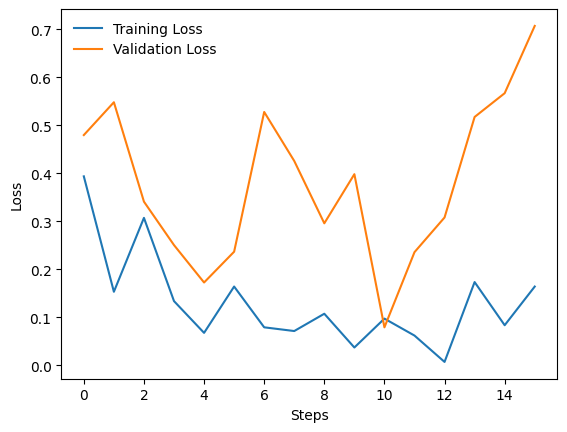

In [29]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

loss가 전반적으로 줄기는 하나 성능 변화 일관성이 없음 (들쑥날쑥) - 
과적합 추정


과적합 완화 방법
- Dropout 레이어 추가
- L2 정규화 (weight_decay) 적용


모델 평가 방법
- 모델이 예측한 값과 실제 라벨을 비교하여 정확도 측정
- torch.max(outputs, 1)를 사용하여 가장 높은 확률을 가진 클래스를 예측

In [30]:
model.eval() # 평가 모드로 전환

correct = 0
total = 0

with torch.no_grad(): # 평가 시 Gradient 계산 X
    for images, labels in test_loader: # 배치 단위로 테스트 데이터 가져오기
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1) # 가장 높은 확률의 클래스 선택
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"accuracy: {accuracy:.2f}%")

accuracy: 86.21%


모델 저장

In [31]:
# state_dict()로 가중치와 편향을 저장
# torch.save(model, "best_model.pth") 로 저장 시 모델 구조까지 저장 됨 -> 구조가 다르면 오류 발생 가능
torch.save(model.state_dict(), "best_model.pth")
print("저장 완료")

저장 완료


In [32]:
# 모델 불러오기
# 현재 선언된 모델에 가중치 적용
# gpu에서 저장된 모델이어도 cpu에서 불러올 수 있도록 설정
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cpu")))

<All keys matched successfully>

# 입력 이미지 예측 테스트

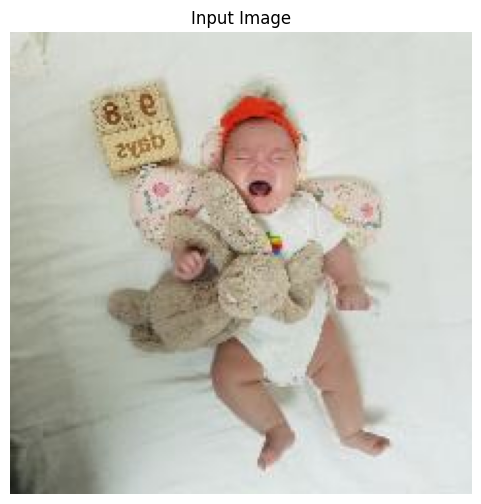

모델 예측 결과: Back (61.56%)


In [42]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.models import ResNet50_Weights
import torch.nn.functional as F  # 🔹 Softmax를 사용하기 위해 추가

# 모델 불러오기 (최신 방식 적용)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Fully Connected Layer 수정 (앞모습: 1, 뒷모습: 0)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # 2개 클래스
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cpu")))  # 학습된 모델 로드
model.eval()  # 평가 모드 전환

# 이미지 변환 설정 (모델과 동일하게 적용)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_image(image_path):
    # 이미지 로드 및 RGB 형식으로 변환
    image = Image.open(image_path).convert("RGB")

    # 이미지 출력
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off") 
    plt.title("Input Image")
    plt.show()

    # 모델 입력을 위한 변환 적용
    image_tensor = transform(image).unsqueeze(0)  # 변환 후 배치 차원 추가

    # 모델 예측
    with torch.no_grad():
        output = model(image_tensor)  # 모델의 원본 출력 (Logits)
        probabilities = F.softmax(output, dim=1)  # 🔹 Softmax 적용 (확률 변환)
        confidence, predicted = torch.max(probabilities, 1)  # 🔹 확률이 가장 높은 클래스 선택

    # 예측 결과 출력
    class_names = ["Back", "Front"]  # 0: Back, 1: Front
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item() * 100  # 🔹 백분율 변환

    print(f"모델 예측 결과: {predicted_class} ({confidence_score:.2f}%)")  # 🔹 확률 추가

# 예측할 이미지
predict_image(r"data\front\front_0004.jpeg")



모델 평가

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader):
    model.eval() # 평가 모드
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cpu"), labels.to("cpu")
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    # 평가
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")
    cm = confusion_matrix(y_true, y_pred)

    # 평가 결과
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # confusion matrix 시각화
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Back", "Front"], yticklabels=["Back", "Front"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy : 0.8621
Precision: 0.800000
Recall: 0.9231
F1-Score: 0.8571


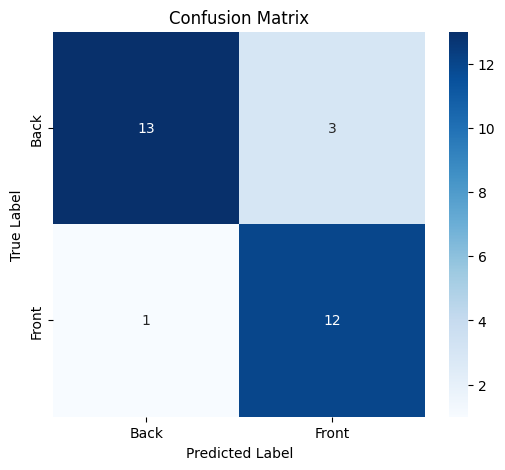

In [44]:
evaluate_model(model, test_loader)